## What is this?
Attempt ot create a baseline model with data from [here](https://www.kaggle.com/thedrcat/g2net-train-images-with-gpwy-sample/)
and [here](https://www.kaggle.com/thedrcat/g2net-test-imgs-with-gwpy/) 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install spacy==3.1.1

     |████████████████████████████████| 6.4 MB 4.4 MB/s 
     |████████████████████████████████| 621 kB 48.6 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 456 kB 47.2 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.5
    Uninstalling thinc-7.4.5:
      Successfully uninstalled thinc-7.4.5
  Attempting uninstall: spacy
    Found existing installation: spacy 2.3.7
    Uninstalling spacy-2.3.7:
      Successfully uninstalled spacy-2.3.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency

In [3]:
#!yes Y|conda install -c fastai fastai=2.4.1
!pip install fastai==2.4.1

     |████████████████████████████████| 188 kB 4.5 MB/s 
     |████████████████████████████████| 22.1 MB 40.3 MB/s 
     |████████████████████████████████| 831.4 MB 1.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.1
    Uninstalling torchvision-0.8.1:
      Successfully uninstalled torchvision-0.8.1
  Attempting uninstall: fastai
    Found existing installation: fastai 2.2.7
    Uninstalling fastai-2.2.7:
      Successfully uninstalled fastai-2.2.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kornia 0.5.5 requires numpy<=1.19, but you have numpy 1.19.5 which is incompatible.
allennlp 2.5.0 requires spacy<3.1,>=2.1.0, but you have spacy 3.1.1 which is incompatible.
all

In [4]:
from pandas.core.frame import DataFrame
from fastai.vision.all import *

## Get the files

In [5]:
path = Path("../input")

## getfiles(path: Path, ext)

In [6]:
def getfiles(path: Path, ext):
    "Get numpy files in `path` recursively, only in `folders`, if specified."
    return L(path.glob(f'**/*.{ext}'))

In [7]:
%%time
files = getfiles(path/'g2net-train-images-with-gpwy-sample', 'png')

CPU times: user 6.51 s, sys: 11.6 s, total: 18.1 s
Wall time: 8min 42s


In [8]:
len(files)

282500

In [9]:
files[-1]

Path('../input/g2net-train-images-with-gpwy-sample/kaggle/tmp/train/24cc5d5bf4.png')

In [10]:
files[-1].name.replace(".png", "")

'24cc5d5bf4'

## Get labels

In [11]:
df = pd.read_csv(path/'g2net-gravitational-wave-detection/training_labels.csv')

In [12]:
df.head(1)

,id,target
0,00000e74ad,1


In [13]:
filtered_df = df.loc[df.id. isin([f.name.replace(".png", "") for f in files])]

In [14]:
filtered_df.head(1)

,id,target
0,00000e74ad,1


## Creating the dataloader

In [15]:
filtered_df.shape

(282500, 2)

In [16]:
sample = filtered_df[:20000]

In [17]:
train_path = path/'g2net-train-images-with-gpwy-sample/kaggle/tmp/train'

ds = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_x=ColReader('id', pref=train_path, suff='.png'),
                splitter=TrainTestSplitter(),
                get_y=ColReader('target'),
                item_tfms=Resize(460),
                batch_tfms=aug_transforms(size=224, flip_vert=True,
                                          max_lighting=0.1, max_zoom=1.05, 
                                          max_warp=0.))

In [18]:
ds.summary(filtered_df)

Setting-up type transforms pipelines
0       00000e74ad       1
2       0000661522       0
6       0000c3b9c9       0
7       0000d61b7b       1
10      000118b40d       0
...            ...     ...
559989  ffff330801       0
559991  ffff5c861a       0
559994  ffff8ae576       1
559998  ffffd2c403       0
559999  fffff2180b       0

[282500 rows x 2 columns]
Found 282500 items
2 datasets of sizes 226000,56500
Setting up Pipeline: ColReader -- {'cols': 'id', 'pref': Path('../input/g2net-train-images-with-gpwy-sample/kaggle/tmp/train'), 'suff': '.png', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 'target', 'pref': '', 'suff': '', 'label_delim': None} -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: ColReader -- {'cols': 'id', 'pref': Path('../input/g2net-train-images-with-gpwy-sample/kaggle/tmp/train'), 'suff': '.png', 'label_delim': None} -> PILBase.create
    starting from
      id        9667be00da
ta

In [19]:
dls = ds.dataloaders(filtered_df, bs=256)

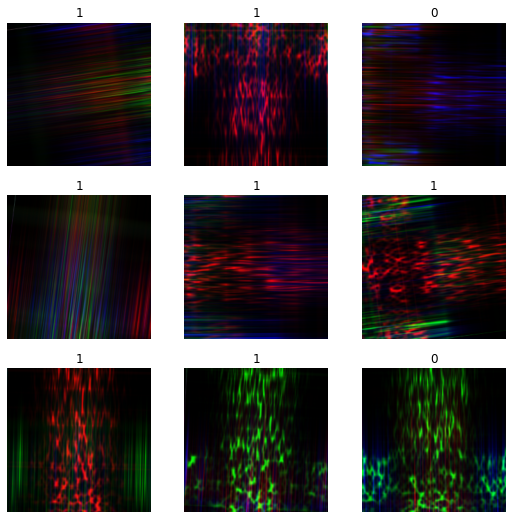

In [20]:
dls.show_batch()

## How does a simple model like resnet would perform?

## The Learner

In [21]:
learn = cnn_learner(dls, resnet34,
                    loss_func=CrossEntropyLossFlat(), metrics=[RocAucBinary(axis=0)]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Train

In [22]:
def show_me_lrs(learn):
    suggestions = namedtuple('Suggestions', ["min", "steep",
                                            "valley", "slide"])
    lr_min, lr_steep,lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep,valley, slide))
    suggested_lrs = suggestions(lr_min, lr_steep, lr_valley, lr_slide)
    
    print(f"Minimum/10:\t{lr_min:.2e}\
          \nSteepest point:\t{lr_steep:.2e}\
          \nLongest valley:\t{lr_valley:.2e}\
          \nSlide interval:\t{lr_slide:.2e}")
    
    return suggested_lrs

In [23]:
learn.fit_one_cycle(2, 3e-3)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.711642,0.697628,0.502526,50:46
1,0.694492,0.693452,0.502972,51:11


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	3.31e-07          
Steepest point:	1.91e-06          
Longest valley:	1.45e-03          
Slide interval:	7.59e-03


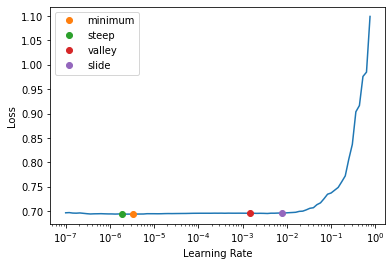

In [24]:
suggested_lrs = show_me_lrs(learn)

In [25]:
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(suggested_lrs.slide/10, suggested_lrs.slide))

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.730693,0.694324,0.501169,46:39
1,0.704264,0.733110,0.498610,43:13
2,0.695170,0.693418,0.495881,44:42
3,0.693594,0.693174,0.502972,44:44
4,0.693250,0.693167,0.504093,45:12


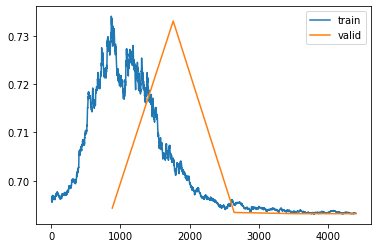

In [26]:
learn.recorder.plot_loss()

## Save trained model

In [27]:
learn.export("./final")